### PINN-based inversion using neural fields

#### The goal is to have a very simple model for something that looks like a spectral line
#### And to retrieve a physically meaningful parameter

#### Should be relatively easy for you to generalize to a similar problem you might have

In [ ]:
import numpy as np
import matplotlib.pyplot as pl
import torch
import torch.nn as nn
import torch.nn.init as init
import skimage.filters as filters
print('pytorch:',torch.__version__)

pytorch: 2.4.0+cu121


#### Let us use a spectral line that is purely Gaussian and parameterized by the depth and the velocity shift. The width of the line is assumed to be fixed and known for this simple model.

#### This can be a model for a very simple absorption line (of course we can also make the width variable if we need)

In [ ]:
# The wavelengths here are given in some arbitrary units

nl = 100
wavel = np.linspace(-1, 1, nl)
depth = 0.4
sigma = 0.2
v = 0.0
y = 1.0 - depth * np.exp(-(wavel-v)**2 / sigma**2)

Text(0, 0.5, 'Intensity [AU]')

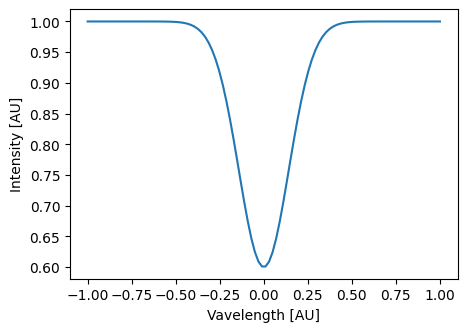

In [ ]:
fig, ax = pl.subplots(figsize=[5,3.5])
ax.plot(wavel, y)
ax.set_xlabel("Vavelength [AU]")
ax.set_ylabel("Intensity [AU]")

#### As a first step, let us consider that the depth is known and we want to infer the per-pixel velocity shift. We generate a shift by getting an array of 50x50 and convolving it with a Gaussian window of 1 pixel width. This introduces spatial correlation and it looks similar to what one sees in the Sun.

Text(0.5, 1.0, 'Spatially filtered random noise')

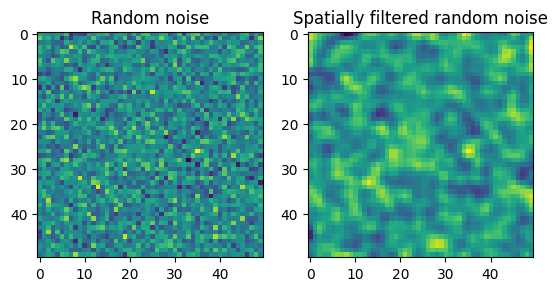

In [ ]:
nx = 50
ny = 50
tmp = np.random.normal(loc=0, scale=0.75, size=(nx, ny))
v = filters.gaussian(tmp, sigma=1)
fig, ax = pl.subplots(nrows=1, ncols=2)
ax[0].imshow(tmp)
ax[1].imshow(v)
ax[0].set_title('Random noise')
ax[1].set_title('Spatially filtered random noise')

#### We use this model for the velocity shift to compute the emergent spectral line at each pixel. Note that we take advantage of numpy broadcasting for doing this calculation without loops.



In [ ]:
stokes = 1.0 - depth * np.exp(-(wavel[None,None,:]-v[:,:,None])**2 / sigma**2)
stokes_noise = stokes + np.random.normal(loc=0, scale=1e-3, size=stokes.shape)

#### The line above produces a synthetic observables that we now want to infer. We pretend we do not know the original velocity.

In [ ]:
stokes.shape

(50, 50, 100)

#### Let's see a few profiles. Note that we have added noise.

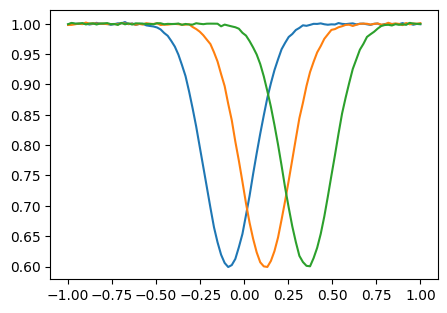

In [ ]:
fig, ax = pl.subplots(figsize=[5,3.5])
ax.plot(wavel, stokes_noise[10, 10, :])
ax.plot(wavel, stokes_noise[20, 20, :])
ax.plot(wavel, stokes_noise[40, 40, :])

#### We want to use "neural fields" to recover the information by taking into account the spatial structure of the observations. To this end, let us first define a grid of points [-1,1]x[-1,1] that span the image in normalized units.

#### Here we are producing (x,y) grid that our NN will map to physical parameters

In [ ]:
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
X, Y = np.meshgrid(x, y)
X = X.reshape((nx*ny))
Y = Y.reshape((nx*ny))

Do we have a GPU to accelerate calculations?

In [ ]:
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Now we define the neural fields. The first thing we define is a random Fourier encoding (https://bmild.github.io/fourfeat/), that we show later it strongly improves the capabilities of the model. Then the neural field is just a mapping from (x,y) to velocity(x,y). To this end, we use a simple neural network that takes (x,y) as input and produces a scalar as output.

![neural field](https://bmild.github.io/fourfeat/img/teaser.png)

In [ ]:
class PositionalEncoding(nn.Module):
    """Positional encoding for the input vector

    gamma(v) = [..., cos(2 * pi * sigma ** (j / m) * v), sin(2 * pi * sigma ** (j / m) * v), ...]

    Parameters
    ----------
    nn : _type_
        _description_
    """
    def __init__(self, sigma, n_freqs, input_size):
        super().__init__()
        self.sigma = sigma
        self.n_freqs = n_freqs
        self.encoding_size = (2 * n_freqs + 1) * input_size

    def forward(self, v, alpha=None):

        n_batch, n_input = v.shape

        if (alpha is None):
            alpha = 1.0

        k = torch.arange(self.n_freqs, device=v.device)

        weight = 0.5 * (1.0 - torch.cos((alpha * self.n_freqs - k) * np.pi))
        weight[alpha * self.n_freqs < k] = 0.0
        weight[alpha * self.n_freqs - k >= 1] = 1.0
        weight = weight[None, None, :]

        coeffs = 2 * np.pi * self.sigma ** (1.0 * k / self.n_freqs)
        vp = coeffs * torch.unsqueeze(v, -1)
        vp_cat = torch.cat((weight * torch.cos(vp), weight * torch.sin(vp)), dim=-1)

        out = vp_cat.flatten(-2, -1)

        out = torch.cat((v, out), dim=-1)

        return out


class GaussianEncoding(nn.Module):
    def __init__(self, input_size, encoding_size, sigma=None):
        super().__init__()
        self.sigma = sigma
        self.input_size = input_size
        self.encoding_size_half = encoding_size
        self.encoding_size = 2 * encoding_size + input_size

        # Fourier matrix
        B = self.sigma * torch.randn((encoding_size, self.input_size))
        self.B_max = torch.max(torch.abs(B))

        # Compute the frequency to reorder the Fourier matrix
        freq = torch.sqrt(torch.sum(B**2, dim=1))
        _, idx = torch.sort(freq, descending=False)
        B = B[idx, :]

        self.register_buffer("B", B)

    def forward(self, v, alpha=None):
        if (alpha is None):
            alpha = 1.0

        k = torch.arange(self.encoding_size_half, device=v.device)

        weight = 0.5 * (1.0 - torch.cos((alpha * self.encoding_size_half - k) * np.pi))
        weight[alpha * self.encoding_size_half < k] = 0.0
        weight[alpha * self.encoding_size_half - k >= 1] = 1.0

        vp = 2.0 * np.pi * v @ self.B.T

        out = torch.cat([weight * torch.cos(vp), weight * torch.sin(vp)], dim=-1)

        out = torch.cat((v, out), dim=-1)

        return out

class IdentityEncoding(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.encoding_size = input_size

    def forward(self, v, alpha=None):

        return v

In [ ]:
def init_kaiming(m):
    if type(m) == nn.Linear:
        init.kaiming_uniform_(m.weight, nonlinearity='relu')

def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module

class MLP(nn.Module):
    def __init__(self, n_input, n_output, dim_hidden=1, n_hidden=1, activation=nn.ReLU(), bias=True, final_activation=nn.Identity(), zero_init=False):
        """Simple fully connected network, potentially including FiLM conditioning

        Parameters
        ----------
        n_input : int
            Number of input neurons
        n_output : int
            Number of output neurons
        n_hidden : int, optional
            number of neurons per hidden layers, by default 1
        n_hidden_layers : int, optional
            Number of hidden layers, by default 1
        activation : _type_, optional
            Activation function to be used at each layer, by default nn.Tanh()
        bias : bool, optional
            Include bias or not, by default True
        final_activation : _type_, optional
            Final activation function at the last layer, by default nn.Identity()
        """
        super().__init__()


        self.activation = activation
        self.final_activation = final_activation

        self.layers = nn.ModuleList([])

        self.layers.append(nn.Linear(n_input, dim_hidden, bias=bias))

        for i in range(n_hidden):
            self.layers.append(nn.Linear(dim_hidden, dim_hidden, bias=bias))

        if (zero_init):
            self.last_layer = zero_module(nn.Linear(dim_hidden, n_output))
        else:
            self.last_layer = nn.Linear(dim_hidden, n_output)
            self.last_layer.apply(init_kaiming)

        self.layers.apply(init_kaiming)

    def forward(self, x, gamma=None, beta=None):

        # Apply all layers
        for layer in self.layers:

            # Apply conditioning if present
            if (gamma is not None):
                x = layer(x) * gamma
            else:
                x = layer(x)

            if (beta is not None):
                x += beta

            x = self.activation(x)

        x = self.last_layer(x)
        x = self.final_activation(x)

        return x

#### Let us see the effect of the Fourier encoding. We instantiate two neural networks, one using (x,y) as inputs and the other one using a Fourier encoding before entering into the network.

In [ ]:
model = MLP(n_input=2, n_output=1, dim_hidden=64, n_hidden=5, zero_init=False).to(device)
encoding = GaussianEncoding(input_size=2, sigma=1.0, encoding_size=64).to(device)
model_encoding = MLP(n_input=encoding.encoding_size, n_output=1, dim_hidden=64, n_hidden=5).to(device)

In [ ]:
X_th = torch.tensor(X.astype('float32')).to(device)
Y_th = torch.tensor(Y.astype('float32')).to(device)
XY = torch.cat([X_th[:, None], Y_th[:, None]], dim=-1)
with torch.no_grad():
    out = model(XY).squeeze().reshape((nx, ny)).cpu().numpy()
    XY_encoded = encoding(XY)
    out_encoding = model_encoding(XY_encoded).squeeze().reshape((nx, ny)).cpu().numpy()

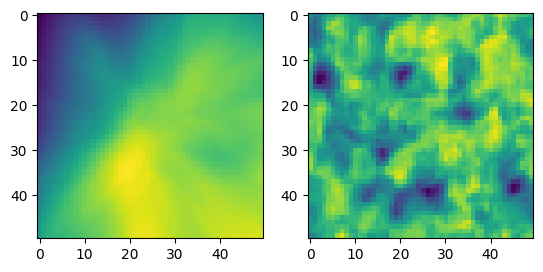

In [ ]:
fig, ax = pl.subplots(ncols=2)
ax[0].imshow(out)
ax[1].imshow(out_encoding)

We see that the frequencies that we end up having with the Fourier encoding are much higher.

We define the neural network (2 inputs, 1 output, 5 hidden layers with 64 neurons each). We transform x and y to PyTorch tensors and instantiate the optimizer.

In [ ]:
model = MLP(n_input=2, n_output=1, dim_hidden=64, n_hidden=5, zero_init=True).to(device)
X_th = torch.tensor(X.astype('float32')).to(device)
Y_th = torch.tensor(Y.astype('float32')).to(device)
stokes_noise_th = torch.tensor(stokes_noise.reshape((nx*ny, nl)).astype('float32')).to(device)
wavel_th = torch.tensor(wavel.astype('float32')).to(device)

lr = 3e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#### Now we do the training loop, that includes an (optional) annealer for the learning rate. At each iteration, we evaluate the Gaussian spectral line at each position in the batch and compare with the observations.

In [ ]:
n_epochs = 150
batch_size = 50

# Divide the image in batches of equal size and randomly sampled in the (x,y) plane
n_batches = nx*ny // batch_size
ind = np.arange(nx*ny)
np.random.shuffle(ind)
ind_th = torch.tensor(ind.astype('int')).to(device)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs, eta_min=0.1*lr)

for epochs in range(n_epochs):
    left = 0
    right = left + batch_size
    for batch in range(n_batches):

        optimizer.zero_grad()

        indices = ind_th[left:right]
        xx = X_th[indices]
        yy = Y_th[indices]
        xy = torch.cat([xx[:, None], yy[:, None]], dim=-1)
        stokes = stokes_noise_th[indices, :]
        velocity = model(xy).squeeze()
        stokes_syn = 1.0 - depth * torch.exp(-(wavel_th[None,:]-velocity[:,None])**2 / sigma**2)
        loss = torch.mean((stokes - stokes_syn)**2)

        loss.backward()
        optimizer.step()

        scheduler.step()

        left += batch_size
        right += batch_size
    print(f'Epoch :{epochs} - L={loss.item()}')

Epoch :0 - L=0.011571437120437622
Epoch :1 - L=0.011386227793991566
Epoch :2 - L=0.01136744674295187
Epoch :3 - L=0.01125765684992075
Epoch :4 - L=0.010931008495390415
Epoch :5 - L=0.010641397908329964
Epoch :6 - L=0.010505990125238895
Epoch :7 - L=0.010605295188724995
Epoch :8 - L=0.010510779917240143
Epoch :9 - L=0.01053493469953537
Epoch :10 - L=0.010639533400535583
Epoch :11 - L=0.010598799213767052
Epoch :12 - L=0.010662034153938293
Epoch :13 - L=0.010973083786666393
Epoch :14 - L=0.010957841761410236
Epoch :15 - L=0.01092980895191431
Epoch :16 - L=0.01089510228484869
Epoch :17 - L=0.010762163437902927
Epoch :18 - L=0.010817336849868298
Epoch :19 - L=0.011030146852135658
Epoch :20 - L=0.011126183904707432
Epoch :21 - L=0.011041389778256416
Epoch :22 - L=0.010905235074460506
Epoch :23 - L=0.010929142124950886
Epoch :24 - L=0.010875878855586052
Epoch :25 - L=0.01102096401154995
Epoch :26 - L=0.011170521378517151
Epoch :27 - L=0.011072280816733837
Epoch :28 - L=0.010871374979615211
E

You can see that convergence is slow. Let's evaluate the model on the 50x50 array of (x,y) coordinates and see the result.

In [ ]:
xy = torch.cat([X_th[:, None], Y_th[:, None]], dim=-1)
with torch.no_grad():
    velocity_final = model(xy).squeeze().reshape((nx, ny)).cpu().numpy()

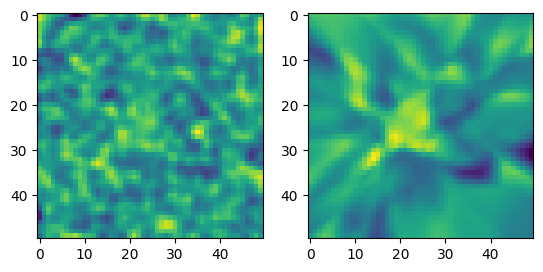

In [ ]:
fig, ax = pl.subplots(nrows=1, ncols=2)
ax[0].imshow(v)
ax[1].imshow(velocity_final)

We see some hints of convergence, but results are not good. The reason for this is the "low-frequency bias" that neural networks have. They are good at representing structures with low spatial frequency, but not if they contain high frequencies. We can do some search over architectures/learning rate/activation functions to see if this improves. Anyway, let's use Fourier mapping as a first layer to see that things improve a lot. This gives a large flexibility to the network to produce high-frequency structures.

## Fourier encoding

In [ ]:
encoding = GaussianEncoding(input_size=2, sigma=1.0, encoding_size=64).to(device)
model = MLP(n_input=encoding.encoding_size, n_output=1, dim_hidden=64, n_hidden=5, zero_init=True).to(device)
X_th = torch.tensor(X.astype('float32')).to(device)
Y_th = torch.tensor(Y.astype('float32')).to(device)
stokes_noise_th = torch.tensor(stokes_noise.reshape((nx*ny, nl)).astype('float32')).to(device)
wavel_th = torch.tensor(wavel.astype('float32')).to(device)

lr = 3e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
tanh = nn.Tanh()

In [ ]:
n_epochs = 50
batch_size = 50
n_batches = nx*ny // batch_size
ind = np.arange(nx*ny)
np.random.shuffle(ind)
ind_th = torch.tensor(ind.astype('int')).to(device)

model.train()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs, eta_min=0.1*lr)

for epochs in range(n_epochs):
    left = 0
    right = left + batch_size
    for batch in range(n_batches):

        optimizer.zero_grad()

        indices = ind_th[left:right]
        xx = X_th[indices]
        yy = Y_th[indices]
        xy = torch.cat([xx[:, None], yy[:, None]], dim=-1)
        stokes = stokes_noise_th[indices, :]
        xy_encoded = encoding(xy)
        velocity = model(xy_encoded).squeeze()
        stokes_syn = 1.0 - depth * torch.exp(-(wavel_th[None,:]-velocity[:,None])**2 / sigma**2)
        loss = torch.mean((stokes - stokes_syn)**2)

        loss.backward()
        optimizer.step()

        #scheduler.step()

        left += batch_size
        right += batch_size
    print(f'Epoch :{epochs} - L={loss.item()}')

Epoch :0 - L=0.011463851667940617
Epoch :1 - L=0.00915105827152729
Epoch :2 - L=0.006304399110376835
Epoch :3 - L=0.004958825651556253
Epoch :4 - L=0.004004352260380983
Epoch :5 - L=0.003205321030691266
Epoch :6 - L=0.0024070872459560633
Epoch :7 - L=0.0018276066984981298
Epoch :8 - L=0.001477719284594059
Epoch :9 - L=0.001214486313983798
Epoch :10 - L=0.0010716087417677045
Epoch :11 - L=0.000938791548833251
Epoch :12 - L=0.0008378997445106506
Epoch :13 - L=0.0007321372395381331
Epoch :14 - L=0.0006091478862799704
Epoch :15 - L=0.0005270604742690921
Epoch :16 - L=0.0004616781952790916
Epoch :17 - L=0.00044003952643834054
Epoch :18 - L=0.00042444837163202465
Epoch :19 - L=0.0004310925432946533
Epoch :20 - L=0.00040040339808911085
Epoch :21 - L=0.0004316620179452002
Epoch :22 - L=0.0020382655784487724
Epoch :23 - L=0.0006847386248409748
Epoch :24 - L=0.0003884727484546602
Epoch :25 - L=0.0005989956553094089
Epoch :26 - L=0.0008363716187886894
Epoch :27 - L=0.00036520574940368533
Epoch :2

In [ ]:
xy = torch.cat([X_th[:, None], Y_th[:, None]], dim=-1)
with torch.no_grad():
    xy_encoded = encoding(xy)
    velocity_final = model(xy_encoded).squeeze().reshape((nx, ny)).cpu().numpy()

Text(0.5, 1.0, 'Inferred')

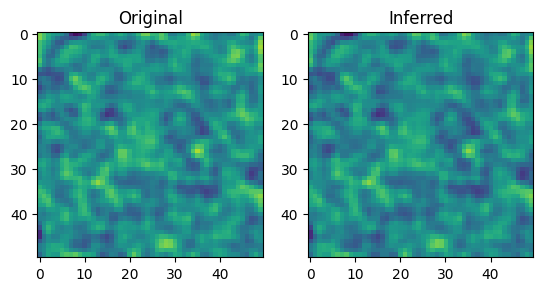

In [ ]:
fig, ax = pl.subplots(nrows=1, ncols=2)
ax[0].imshow(v, vmin = -1, vmax = 1)
ax[0].set_title("Original")
ax[1].imshow(velocity_final, vmin = -1, vmax = 1)
ax[1].set_title("Inferred")

We see that the results are much better now, with a much faster convergence. Since the neural field is continuous, we can now evaluate it wherever we want. For instance, let us focus on the upper left part of the field-of-view and evaluate it in a finer grid.

In [ ]:
nx_zoom = 150
ny_zoom = 150
x_zoom = np.linspace(-1.0, 0.0, nx_zoom)
y_zoom = np.linspace(-1.0, 0.0, ny_zoom)
X_zoom, Y_zoom = np.meshgrid(x_zoom, y_zoom)
X_zoom = X_zoom.reshape((nx_zoom*ny_zoom))
Y_zoom = Y_zoom.reshape((nx_zoom*ny_zoom))
X_th_zoom = torch.tensor(X_zoom.astype('float32')).to(device)
Y_th_zoom = torch.tensor(Y_zoom.astype('float32')).to(device)
xy = torch.cat([X_th_zoom[:, None], Y_th_zoom[:, None]], dim=-1)
with torch.no_grad():
    xy_encoded = encoding(xy)
    velocity_final_zoom = model(xy_encoded).squeeze().reshape((nx_zoom, ny_zoom)).cpu().numpy()

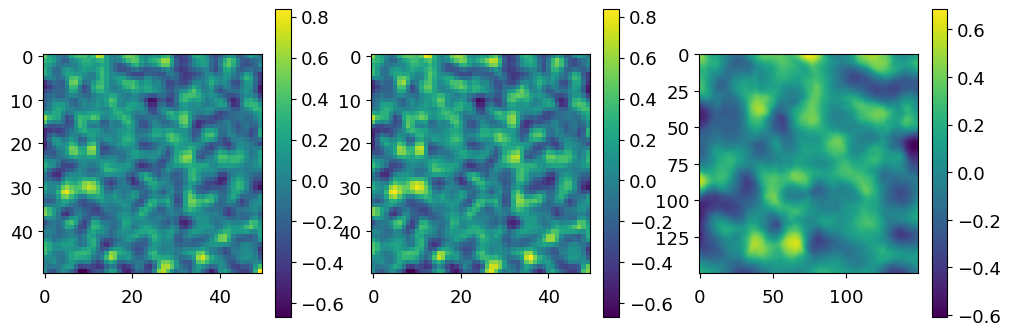

In [ ]:
fig, ax = pl.subplots(nrows=1, ncols=3, figsize=(12,4))
im = ax[0].imshow(v)
pl.colorbar(im, ax=ax[0])
ax[1].imshow(velocity_final)
im = pl.colorbar(im, ax=ax[1])
im = ax[2].imshow(velocity_final_zoom)
pl.colorbar(im, ax=ax[2])

# Infer two quantities
Now, let's add the depth of the line as a new variable and try to recover both from observations. We assume that depth changes with a much larger spatial frequency.

Text(0.5, 1.0, 'Spatially filtered random noise')

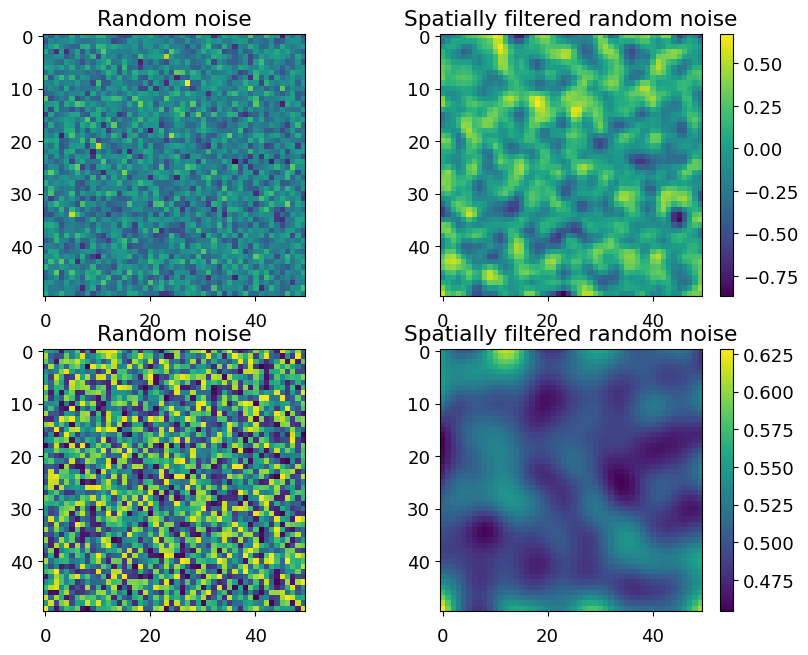

In [ ]:
nx = 50
ny = 50
tmp1 = np.random.normal(loc=0, scale=0.75, size=(nx, ny))
v = filters.gaussian(tmp1, sigma=1)

tmp2 = np.random.uniform(low=0.1, high=0.9, size=(nx, ny))
depth = filters.gaussian(tmp2, sigma=3)

fig, ax = pl.subplots(nrows=2, ncols=2)
ax[0,0].imshow(tmp1)
im = ax[0,1].imshow(v)
ax[0,0].set_title('Random noise')
ax[0,1].set_title('Spatially filtered random noise')
pl.colorbar(im, ax=ax[0,1])
ax[1,0].imshow(tmp2)
im = ax[1,1].imshow(depth)
pl.colorbar(im, ax=ax[1,1])
ax[1,0].set_title('Random noise')
ax[1,1].set_title('Spatially filtered random noise')

We compute the synthetic observations and add noise.

In [ ]:
stokes = 1.0 - depth[:,:,None] * np.exp(-(wavel[None,None,:]-v[:,:,None])**2 / sigma**2)
stokes_noise = stokes + np.random.normal(loc=0, scale=1e-3, size=stokes.shape)

We use a trick to activate low spatial frequencies first and then monotonically add the high frequencies. This usually gives good results, but you can see what happens if you remove it.

In [ ]:
alpha_initial_iteration = 0
alpha_final_iteration = 1500

def alpha_schedule(iter):
    if (iter < alpha_initial_iteration):
        y = 0.0
    elif (iter > alpha_final_iteration):
        y = 1.0
    else:
        x0 = alpha_initial_iteration
        x1 = alpha_final_iteration
        y0 = 0.0
        y1 = 1.0
        y = np.clip((y1 - y0) / (x1 - x0) * (iter - x0) + y0, y0, y1)

    return torch.tensor(float(y)).to(device)

In [ ]:
encoding = GaussianEncoding(input_size=2, sigma=1.0, encoding_size=64).to(device)
model = MLP(n_input=encoding.encoding_size, n_output=2, dim_hidden=64, n_hidden=5).to(device)
X_th = torch.tensor(X.astype('float32')).to(device)
Y_th = torch.tensor(Y.astype('float32')).to(device)
stokes_noise_th = torch.tensor(stokes_noise.reshape((nx*ny,nl)).astype('float32')).to(device)
wavel_th = torch.tensor(wavel.astype('float32')).to(device)

lr = 3e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
n_epochs = 150
batch_size = 50
n_batches = nx*ny // batch_size
ind = np.arange(nx*ny)
np.random.shuffle(ind)
ind_th = torch.tensor(ind.astype('int')).to(device)

alpha = torch.tensor(0.0).to(device)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs, eta_min=0.1*lr)

iter = 0

for epochs in range(n_epochs):
    left = 0
    right = left + batch_size
    for batch in range(n_batches):

        optimizer.zero_grad()

        indices = ind_th[left:right]
        xx = X_th[indices]
        yy = Y_th[indices]
        xy = torch.cat([xx[:, None], yy[:, None]], dim=-1)
        stokes = stokes_noise_th[indices, :]

        # If you don't want to use the alpha annealing, just use alpha=1.0
        xy_encoded = encoding(xy, alpha=alpha)
        out = model(xy_encoded)
        velocity_th = out[:, 0]
        depth_th = out[:, 1]
        stokes_syn = 1.0 - depth_th[:, None] * torch.exp(-(wavel_th[None,:]-velocity_th[:,None])**2 / sigma**2)
        loss = torch.mean((stokes - stokes_syn)**2)

        loss.backward()
        optimizer.step()

        scheduler.step()

        # Update alpha in the range [0,1], all frequencies are active when alpha=1
        alpha = torch.clamp(alpha_schedule(iter), 0.0, 1.0)
        iter += 1

        left += batch_size
        right += batch_size
    print(f'Epoch :{epochs} - L={loss.item()} - iter={iter} - alpha={alpha}')

Epoch :0 - L=0.018551871180534363 - iter=50 - alpha=0.03266666829586029
Epoch :1 - L=0.01916603557765484 - iter=100 - alpha=0.06599999964237213
Epoch :2 - L=0.019084332510828972 - iter=150 - alpha=0.09933333098888397
Epoch :3 - L=0.018893476575613022 - iter=200 - alpha=0.1326666623353958
Epoch :4 - L=0.019100815057754517 - iter=250 - alpha=0.16599999368190765
Epoch :5 - L=0.017925264313817024 - iter=300 - alpha=0.1993333399295807
Epoch :6 - L=0.016456829383969307 - iter=350 - alpha=0.23266667127609253
Epoch :7 - L=0.01754508726298809 - iter=400 - alpha=0.26600000262260437
Epoch :8 - L=0.017482034862041473 - iter=450 - alpha=0.2993333339691162
Epoch :9 - L=0.017545552924275398 - iter=500 - alpha=0.33266666531562805
Epoch :10 - L=0.017005212604999542 - iter=550 - alpha=0.3659999966621399
Epoch :11 - L=0.015925796702504158 - iter=600 - alpha=0.39933332800865173
Epoch :12 - L=0.01580987311899662 - iter=650 - alpha=0.4326666593551636
Epoch :13 - L=0.017158037051558495 - iter=700 - alpha=0.4

In [ ]:
xy = torch.cat([X_th[:, None], Y_th[:, None]], dim=-1)
with torch.no_grad():
    xy_encoded = encoding(xy)
    out = model(xy_encoded).squeeze().reshape((nx, ny, 2)).cpu().numpy()

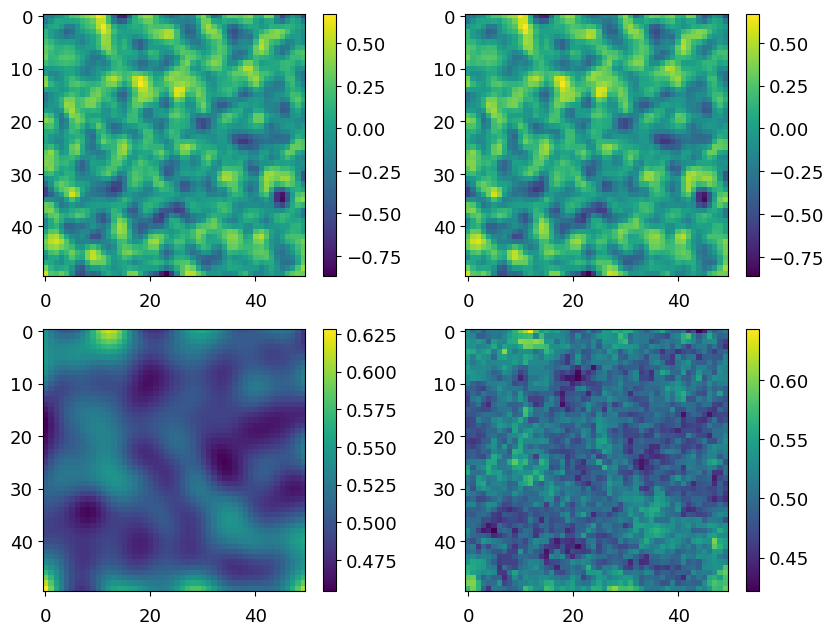

In [ ]:
fig, ax = pl.subplots(nrows=2, ncols=2)
im = ax[0, 0].imshow(v)
pl.colorbar(im, ax=ax[0,0])
im = ax[0, 1].imshow(out[:, :, 0])
pl.colorbar(im, ax=ax[0,1])
im = ax[1, 0].imshow(depth)
pl.colorbar(im, ax=ax[1,0])
im = ax[1, 1].imshow(out[:, :, 1])
pl.colorbar(im, ax=ax[1,1])